# Research Question 5: Analysing the correlation between embeddings similarity and subgroup disparities

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import decomposition
import numpy as np
from scipy import stats
from scipy.spatial import distance
from statsmodels.stats.multitest import multipletests
np.set_printoptions(suppress=True,formatter={'float_kind': '{:f}'.format})
plt.rcParams['figure.dpi'] = 50

In [2]:
def create_pca(
        embeds_array: np.ndarray,
        model_df: pd.DataFrame
    ):
    
    # n -> number of samples
    # m -> number of features
    n, m = embeds_array.shape
    pca = decomposition.PCA(n_components=0.99, whiten=False)
    embeds_pca = pca.fit_transform(embeds_array)

    mu = pca.mean_
    U = pca.components_.T
    D = pca.singular_values_**2 / (n - 1)
    exp_var = pca.explained_variance_ratio_

    model_df['PCA 1'] = embeds_pca[:,0]
    model_df['PCA 2'] = embeds_pca[:,1]
    model_df['PCA 3'] = embeds_pca[:,2]
    model_df['PCA 4'] = embeds_pca[:,3]

    # Replace numerical labels with categorical
    model_df['Targets'] = model_df['Targets'].replace({0: 'No finding', 1: 'Other'})
    model_df['Sex'] = model_df['Sex'].replace({0: 'Male', 1: 'Female'})
    model_df['Age'] = model_df['Age'].replace({0: '<60', 1: '60+'})
    model_df['Race'] = model_df['Race'].replace({0: 'White', 1: 'Non-White'})

In [3]:
from scipy.stats import gaussian_kde

def create_sim_table(
    df: pd.DataFrame,
):
    
    def js_simlarity(marginal, samples):
        df_female = samples[samples['Sex'] == 'Female']
        df_male = samples[samples['Sex'] == 'Male']
        df_young = samples[samples['Age'] == '<60']
        df_old = samples[samples['Age'] == '60+']
        df_white = samples[samples['Race'] == 'White']
        df_non_white = samples[samples['Race'] == 'Non-White']
        df_no_fnd = samples[samples['Targets'] == 'No finding']
        df_other = samples[samples['Targets'] == 'Other']

        def get_js_distance(data_1, data_2):
            # Generate an array of 1000 values between the min and max of both datasets. This serve as the range over which PDFs will be estimated
            x = np.linspace(min(np.min(data_1), np.min(data_2)), max(np.max(data_1), np.max(data_2)), num=1000)

            # Compute Univariate Kernel Density Estimate for both datasets
            pdf1 = gaussian_kde(data_1)(x)
            pdf2 = gaussian_kde(data_2)(x)

            # Normalise
            pdf1 /= np.sum(pdf1)
            pdf2 /= np.sum(pdf2)

            # To avoid div by 0
            epsilon = 1e-10
            pdf1 += epsilon
            pdf2 += epsilon

            return distance.jensenshannon(pdf1, pdf2, base=2)

        sim_label = get_js_distance(df_no_fnd[marginal], df_other[marginal])
        sim_age = get_js_distance(df_young[marginal], df_old[marginal])
        sim_sex = get_js_distance(df_male[marginal], df_female[marginal])
        sim_race = get_js_distance(df_white[marginal], df_non_white[marginal])

        return [sim_label, sim_sex, sim_age, sim_race]
    
    sim_pca1 = js_simlarity('PCA 1', df)
    sim_pca2 = js_simlarity('PCA 2', df)
    sim_pca3 = js_simlarity('PCA 3', df)
    sim_pca4 = js_simlarity('PCA 4', df)

    index = ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4']
    columns = ['label_dist', 'sex_dist', 'age_dist', 'race_dist']
    df_sim = pd.DataFrame([sim_pca1, sim_pca2, sim_pca3, sim_pca4], index=index, columns=columns)

    return df_sim
    


In [4]:
MODEL_FEATURES = {
    'resnet18': 512,
    'resnet34': 512,
    'resnet50': 2048,
    'resnet101': 2048,
}
RANDOM_STATE = 42

In [11]:
def create_data(
    model_dir: str,
    sample: bool = False,
    metric: str = 'auc',
    is_relative: bool = True,
):

    # Look for the folders that have 'sam1' in them
    folders = [f for f in os.listdir(model_dir) if 'sam1' in f]

    # Go to each folder and load 'embeds.csv' and 'test_predictions.csv'
    data = []
    for folder in folders:
        df = pd.read_csv(f'{model_dir}/{folder}/test.csv')

        df[f'age_{metric}'] = (df[f'age_{metric}_group_0'] + df[f'age_{metric}_group_1']) / 2
        df[f'sex_{metric}'] = (df[f'sex_{metric}_group_0'] + df[f'sex_{metric}_group_1']) / 2
        df[f'race_{metric}'] = (df[f'race_{metric}_group_0'] + df[f'race_{metric}_group_1']) / 2

        df[f'age_{metric}_gap'] = abs(df[f'age_{metric}_group_0'] - df[f'age_{metric}_group_1'])
        df[f'sex_{metric}_gap'] = abs(df[f'sex_{metric}_group_0'] - df[f'sex_{metric}_group_1'])
        df[f'race_{metric}_gap'] = abs(df[f'race_{metric}_group_0'] - df[f'race_{metric}_group_1'])
        df[f'avg_{metric}_gap'] = (df[f'age_{metric}_gap'] + df[f'sex_{metric}_gap'] + df[f'race_{metric}_gap']) / 3

        df[f'age_{metric}_gap_relative'] = df[f'age_{metric}_gap'] / df[metric]
        df[f'sex_{metric}_gap_relative'] = df[f'sex_{metric}_gap'] / df[metric]
        df[f'race_{metric}_gap_relative'] = df[f'race_{metric}_gap'] / df[metric]
        df[f'avg_{metric}_gap_relative'] = df[f'avg_{metric}_gap'] / df[metric]

        # Create PCA
        embeds_df = pd.read_csv(f'{model_dir}/{folder}/embeds.csv')
        embeds = np.array(embeds_df.iloc[:,0:MODEL_FEATURES[df['model_name'].iloc[0]]])

        create_pca(embeds, embeds_df) # this gives errors because we don't want to store it actually
        sim_df = create_sim_table(embeds_df)


        # Compute the average of 'PCA 1' and 'PCA 2'
        avg = sim_df.loc[['PCA 1', 'PCA 2']].mean(axis=0)
        avg.name = 'PCA 1 & 2'
        sim_df = sim_df.append(avg)
        avg = sim_df.loc[['PCA 3', 'PCA 4']].mean(axis=0)
        avg.name = 'PCA 3 & 4'
        sim_df = sim_df.append(avg)
        avg = sim_df.loc[['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4']].mean(axis=0)
        avg.name = 'PCA Avg'
        sim_df = sim_df.append(avg)

        sim_df = sim_df.reset_index()
        sim_df = sim_df.rename(columns={'index': 'PCA'})

        sim_df['model_id'] = folder
        sim_df['model_name'] = df['model_name'].iloc[0]

        if is_relative:
            sim_df[f'avg_{metric}_gap_relative'] = df[f'avg_{metric}_gap_relative'].values[0]
            sim_df[f'age_{metric}_gap_relative'] = df[f'age_{metric}_gap_relative'].values[0]
            sim_df[f'sex_{metric}_gap_relative'] = df[f'sex_{metric}_gap_relative'].values[0]
            sim_df[f'race_{metric}_gap_relative'] = df[f'race_{metric}_gap_relative'].values[0]
        else:
            sim_df[f'avg_{metric}_gap'] = df[f'avg_{metric}_gap'].values[0]
            sim_df[f'age_{metric}_gap'] = df[f'age_{metric}_gap'].values[0]
            sim_df[f'sex_{metric}_gap'] = df[f'sex_{metric}_gap'].values[0]
            sim_df[f'race_{metric}_gap'] = df[f'race_{metric}_gap'].values[0]

        data.append(sim_df)

        # if len(data) == 5:
        #     break

    df = pd.concat(data)

    # Create DF For Scatter Plot
    scatter_df = df[df['PCA'].isin(['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'])]
    attributes = ['sex', 'age', 'race']
    rows = []
    for _, row in scatter_df.iterrows():
        for attr in attributes:
            pca_value = row['PCA']
            attribute_value = attr
            pca_dist_value = row[f'{attr}_dist']
            metric_gap_relative_value = row[f'{attr}_{metric}_gap_relative']
            rows.append([pca_value, attribute_value, metric_gap_relative_value, pca_dist_value])
    new_df = pd.DataFrame(rows, columns=['PCA', 'attribute', f'{metric}_gap_relative', 'PCA_dist'])

    # Create DF for Heatmap
    dist_metrics = ['sex_dist', 'age_dist', 'race_dist']
    correlations = pd.DataFrame(index=['sex', 'age', 'race'])

    # Calculate correlations for each PCA category
    for pca_value in df['PCA'].unique():
        corr_values = []
        subset = df[df['PCA'] == pca_value]

        for m in dist_metrics:
            attribute = m.split('_')[0]
            if is_relative:
                corr = subset[f'{attribute}_{metric}_gap_relative'].corr(subset[m])
            else:
                corr = subset[f'{attribute}_{metric}_gap'].corr(subset[m])
            corr_values.append(corr)
        correlations[pca_value] = corr_values

    return df, new_df, correlations


In [ ]:
auc_df, auc_scatter_df, auc_correlations = create_data('../../results/chexpert/resnet/')

In [ ]:
f1_df, f1_scatter_df, f1_correlations = create_data('../../results/chexpert/resnet/', metric='f1')

In [ ]:
youden_df, youden_scatter_df, youden_correlations = create_data('../../results/chexpert/resnet/', metric='youden')

## HeatMap

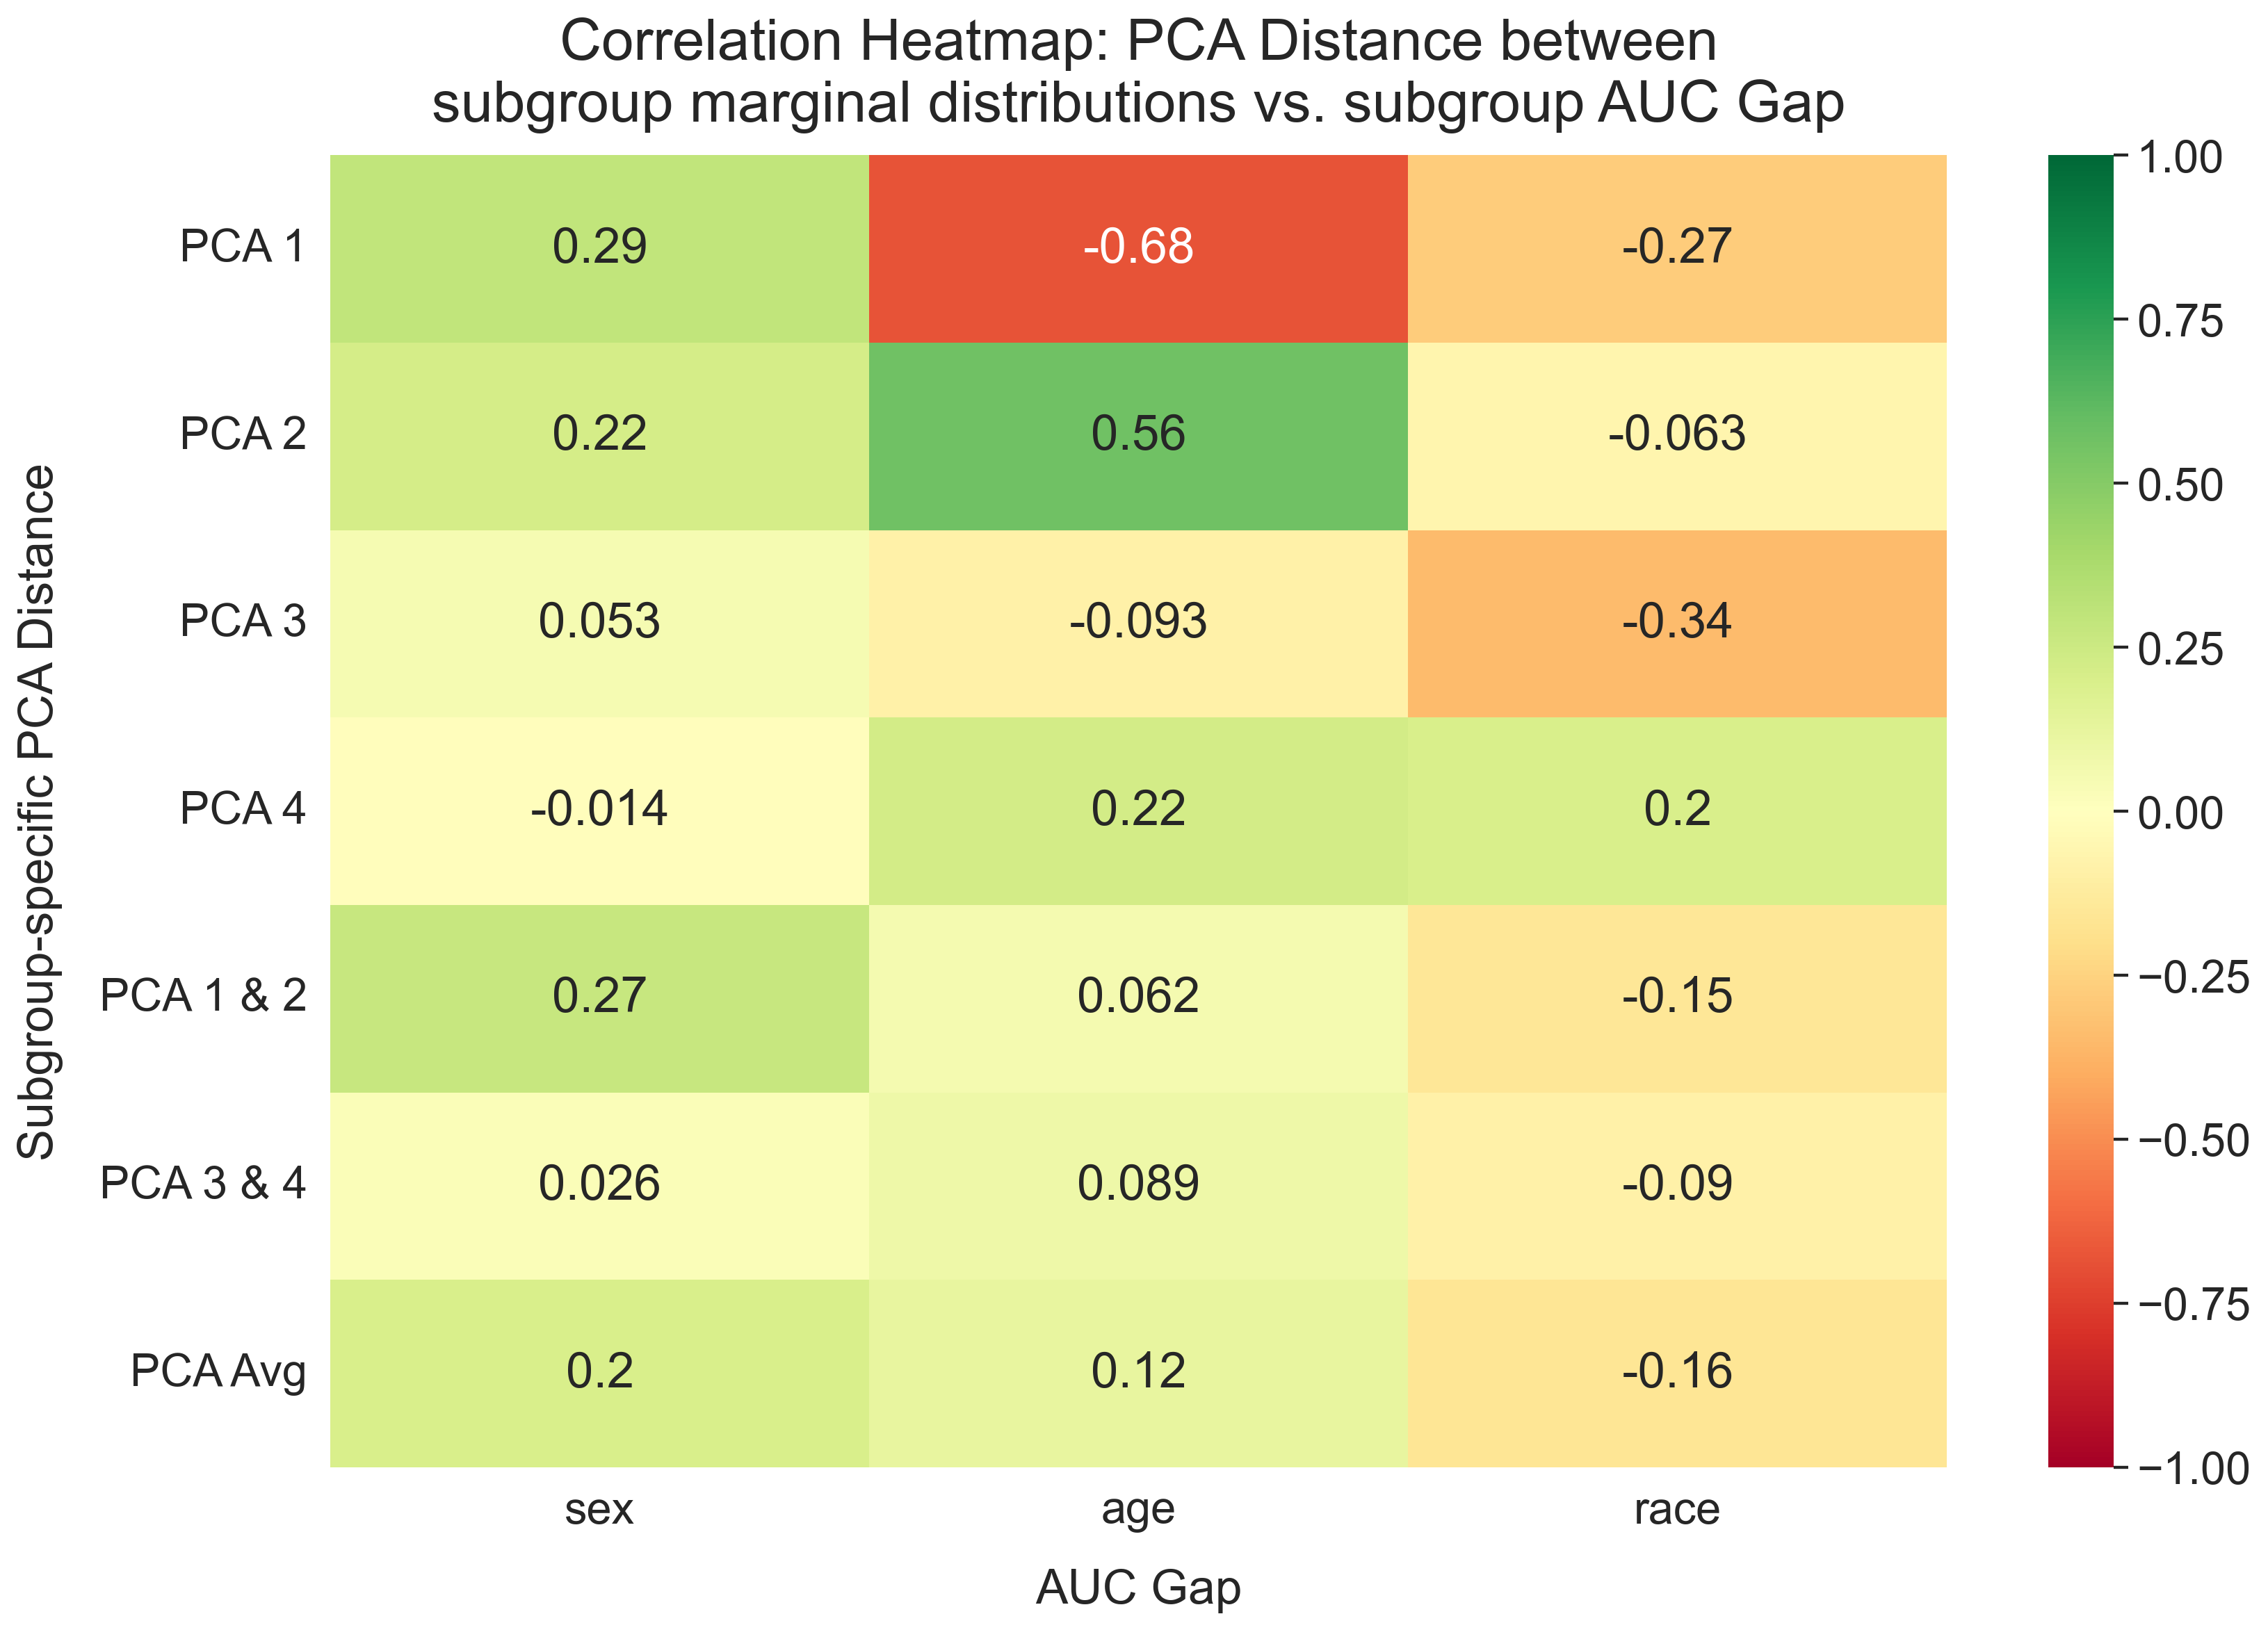

In [28]:
plt.rcParams['figure.dpi'] = 250

# Increase the font scale
sns.set(font_scale=1.7)

plt.figure(figsize=(15, 10))
# Using a red-to-green color palette
sns.heatmap(auc_correlations.T, cmap='RdYlGn', annot=True, vmin=-1, vmax=1)

# Adding an overall title
plt.title("Correlation Heatmap: PCA Distance between\nsubgroup marginal distributions vs. subgroup AUC Gap", fontsize=24, y=1.015)

# Adding titles to x and y axes
plt.xlabel("AUC Gap", fontsize=20, labelpad=15)
plt.ylabel("Subgroup-specific PCA Distance", fontsize=20, labelpad=15)

# Set y-labels to be horizontal
plt.yticks(rotation=0)

plt.show()

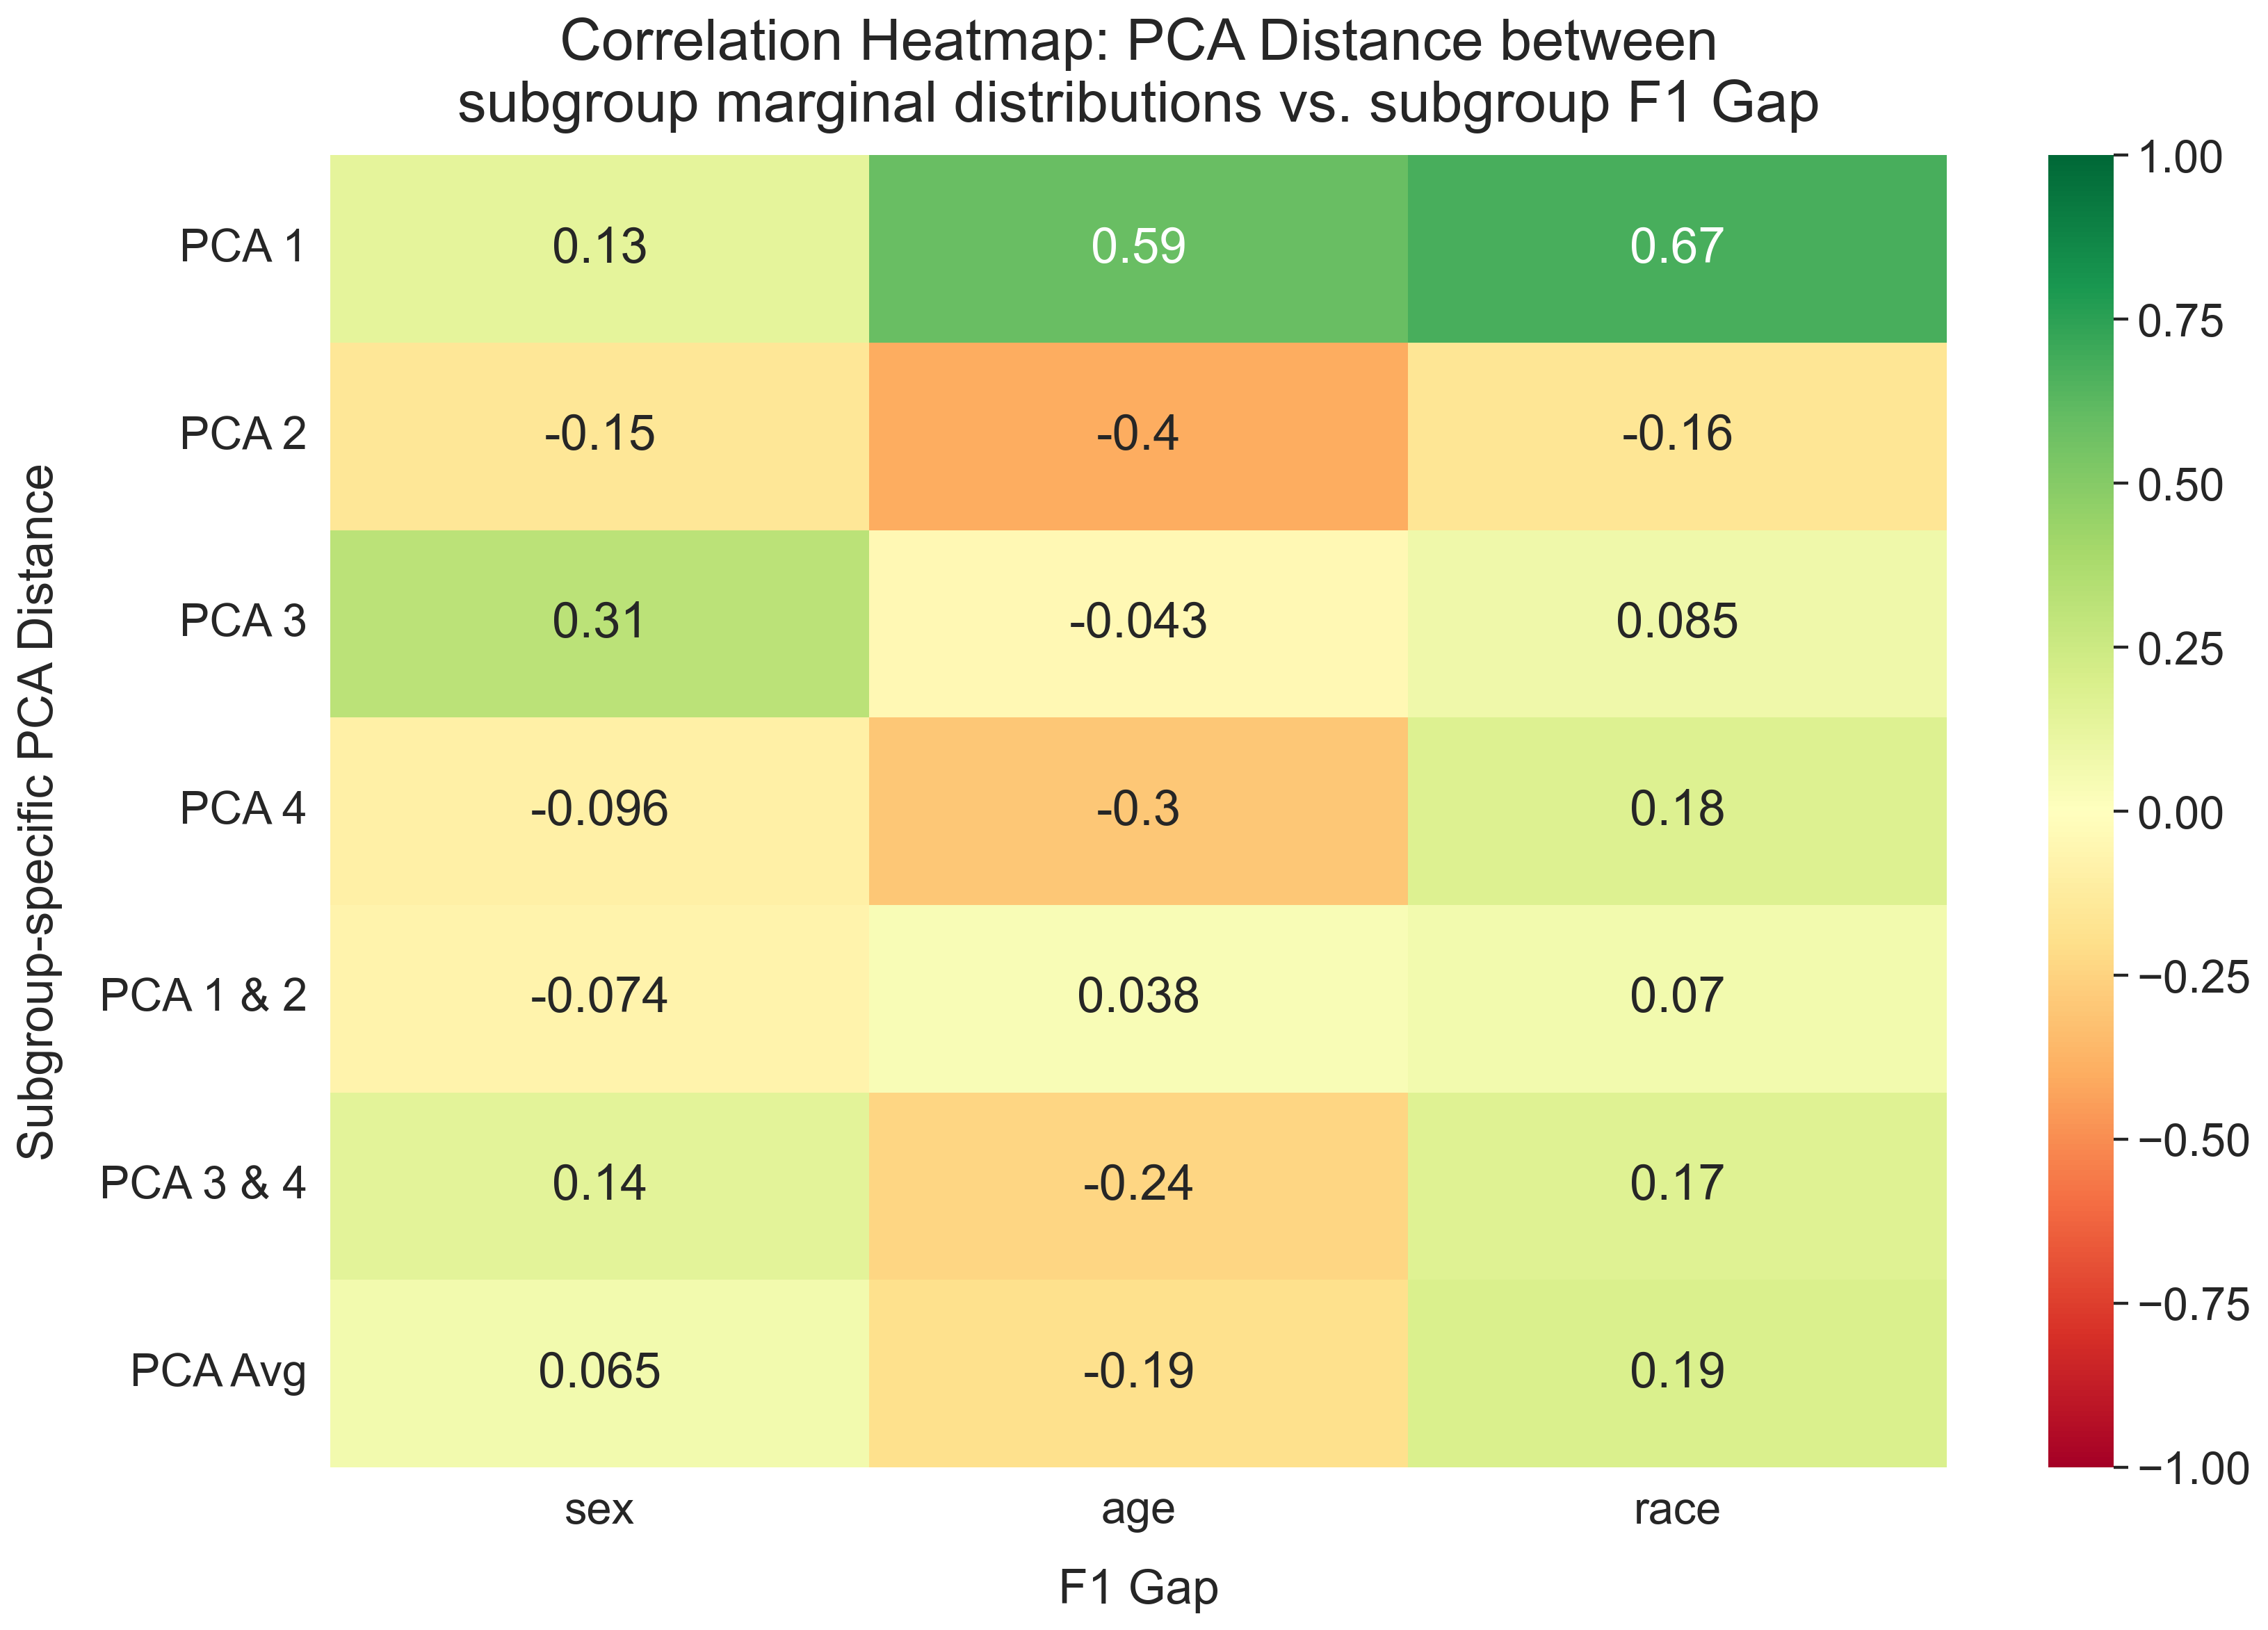

In [29]:
plt.rcParams['figure.dpi'] = 250

# Increase the font scale
sns.set(font_scale=1.7)

plt.figure(figsize=(15, 10))
# Using a red-to-green color palette
sns.heatmap(f1_correlations.T, cmap='RdYlGn', annot=True, vmin=-1, vmax=1)

# Adding an overall title
plt.title("Correlation Heatmap: PCA Distance between\nsubgroup marginal distributions vs. subgroup F1 Gap", fontsize=24, y=1.015)

# Adding titles to x and y axes
plt.xlabel("F1 Gap", fontsize=20, labelpad=15)
plt.ylabel("Subgroup-specific PCA Distance", fontsize=20, labelpad=15)

# Set y-labels to be horizontal
plt.yticks(rotation=0)

plt.show()

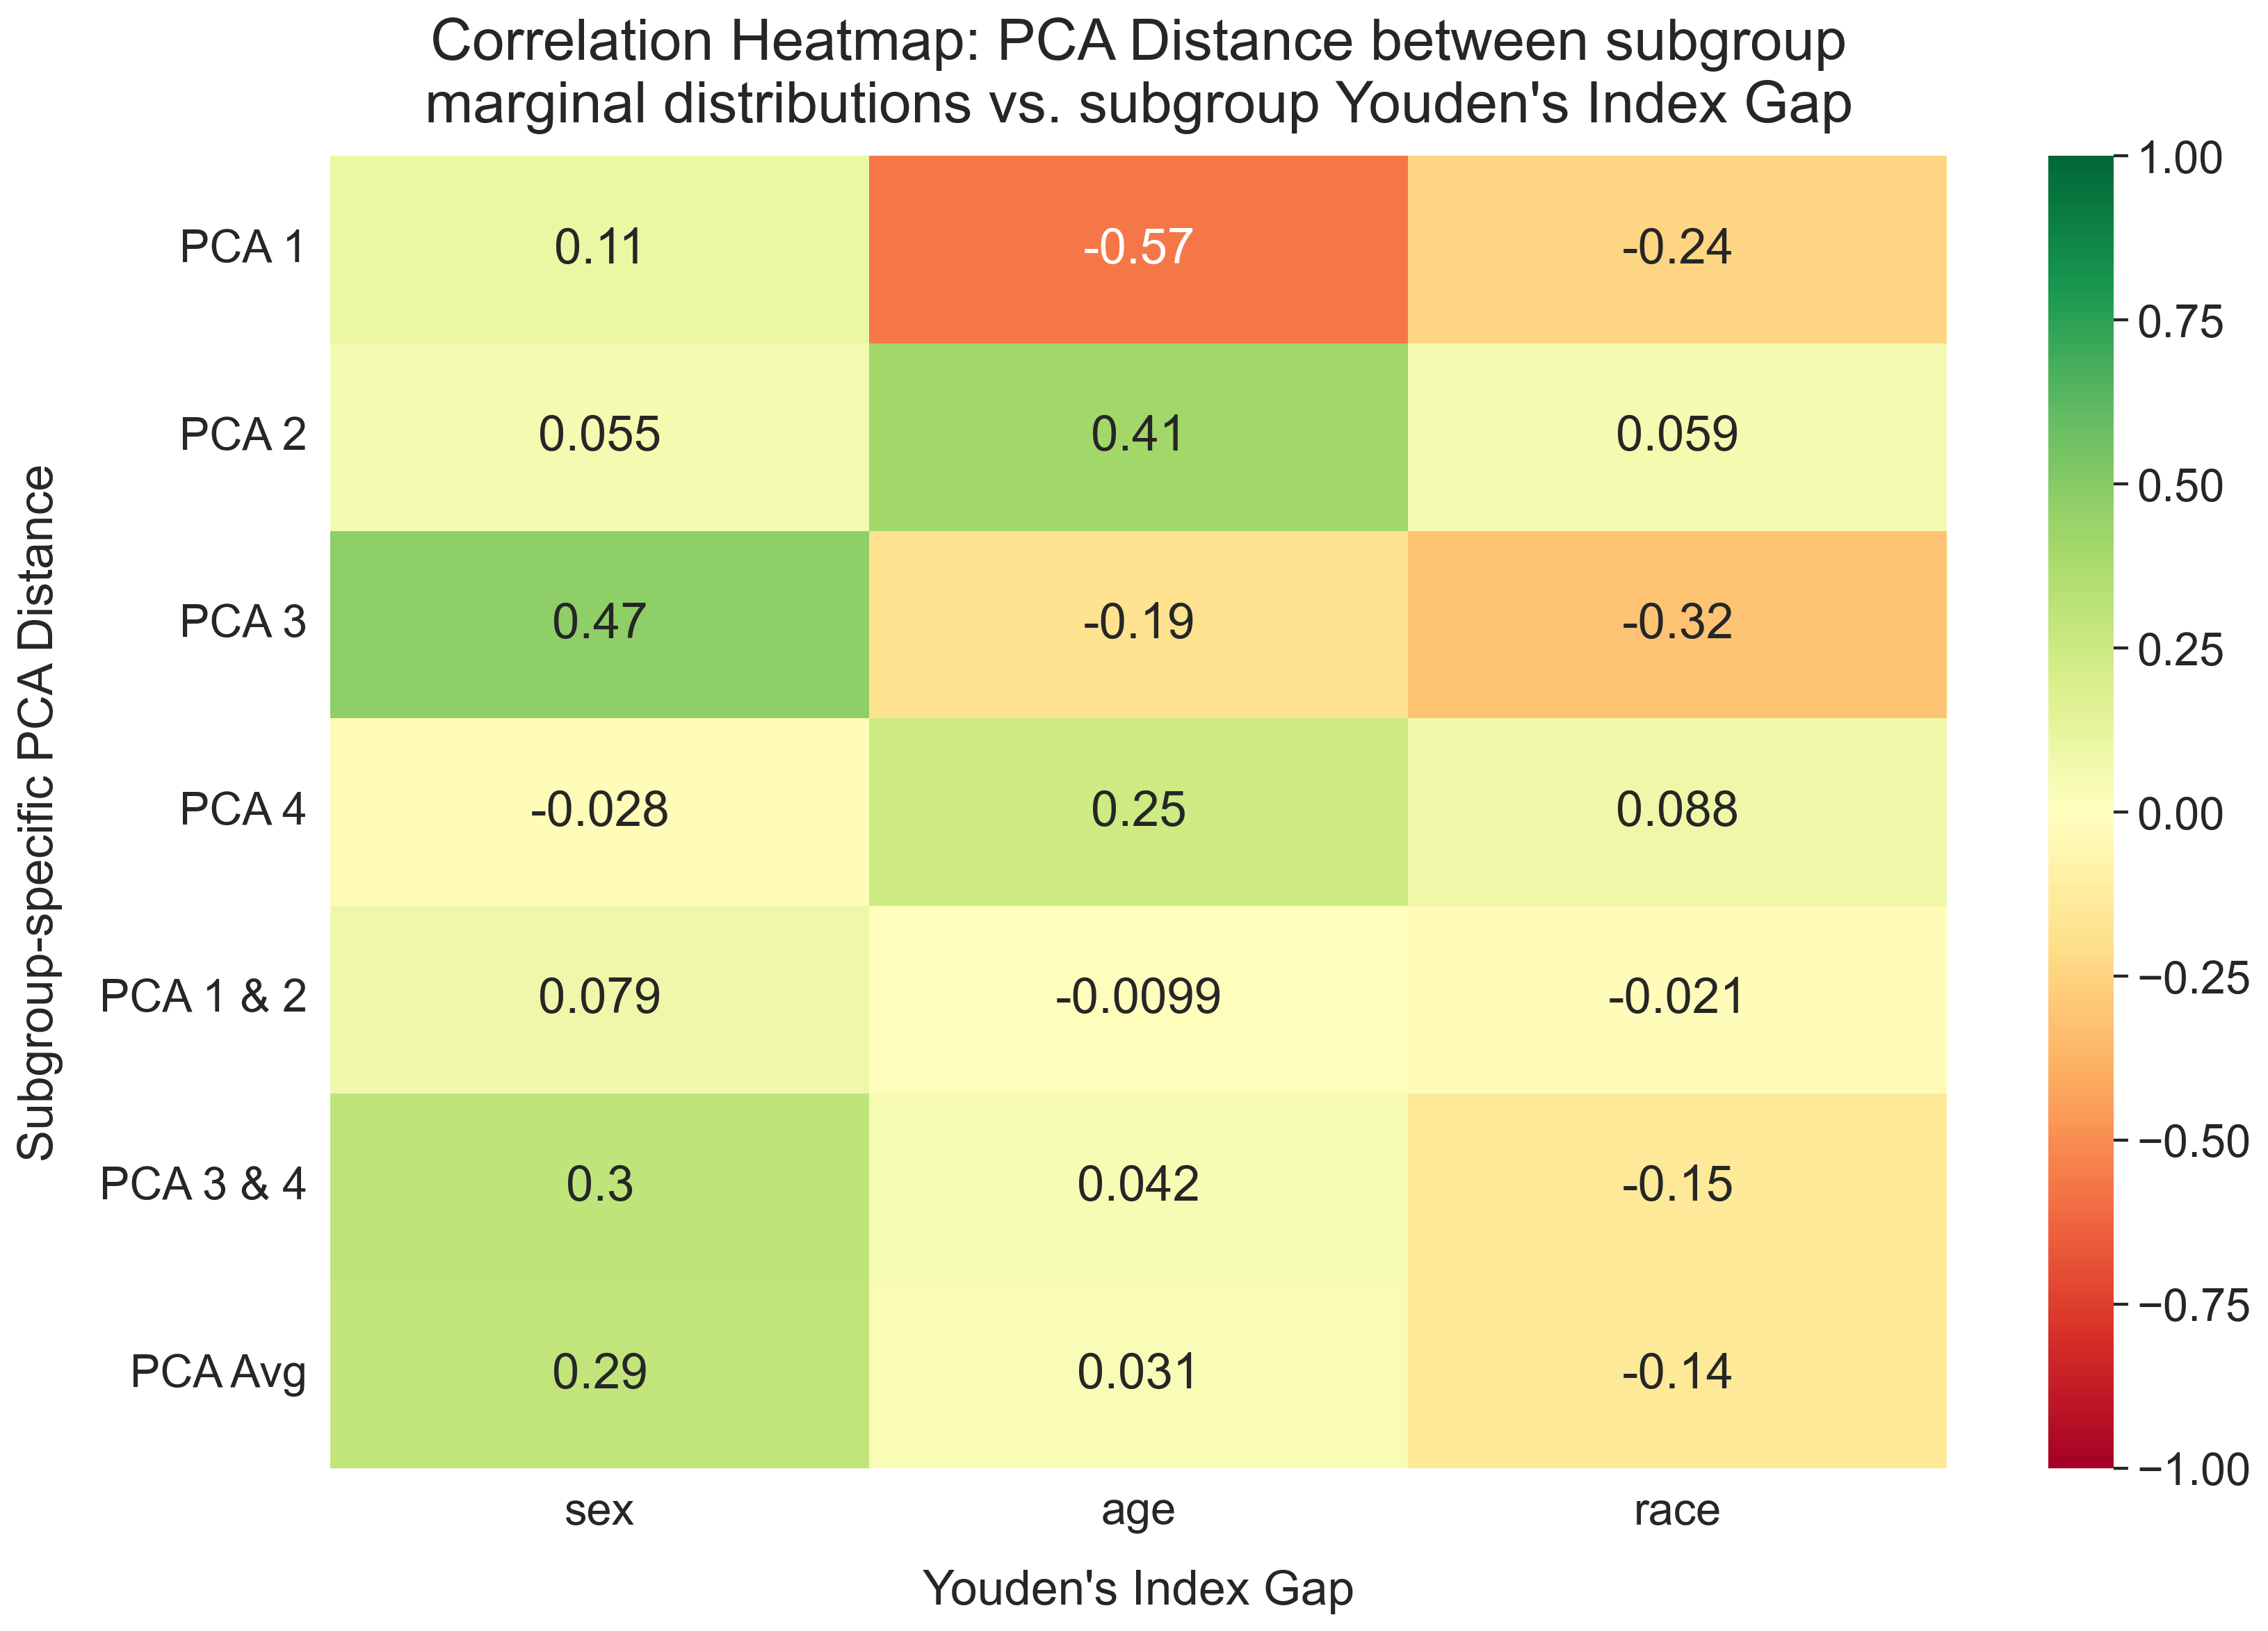

In [30]:
plt.rcParams['figure.dpi'] = 250

# Increase the font scale
sns.set(font_scale=1.7)

plt.figure(figsize=(15, 10))
# Using a red-to-green color palette
sns.heatmap(youden_correlations.T, cmap='RdYlGn', annot=True, vmin=-1, vmax=1)

# Adding an overall title
plt.title("Correlation Heatmap: PCA Distance between subgroup\nmarginal distributions vs. subgroup Youden's Index Gap", fontsize=24, y=1.015)

# Adding titles to x and y axes
plt.xlabel("Youden's Index Gap", fontsize=20, labelpad=15)
plt.ylabel("Subgroup-specific PCA Distance", fontsize=20, labelpad=15)

# Set y-labels to be horizontal
plt.yticks(rotation=0)

plt.show()

## Scatter Plot

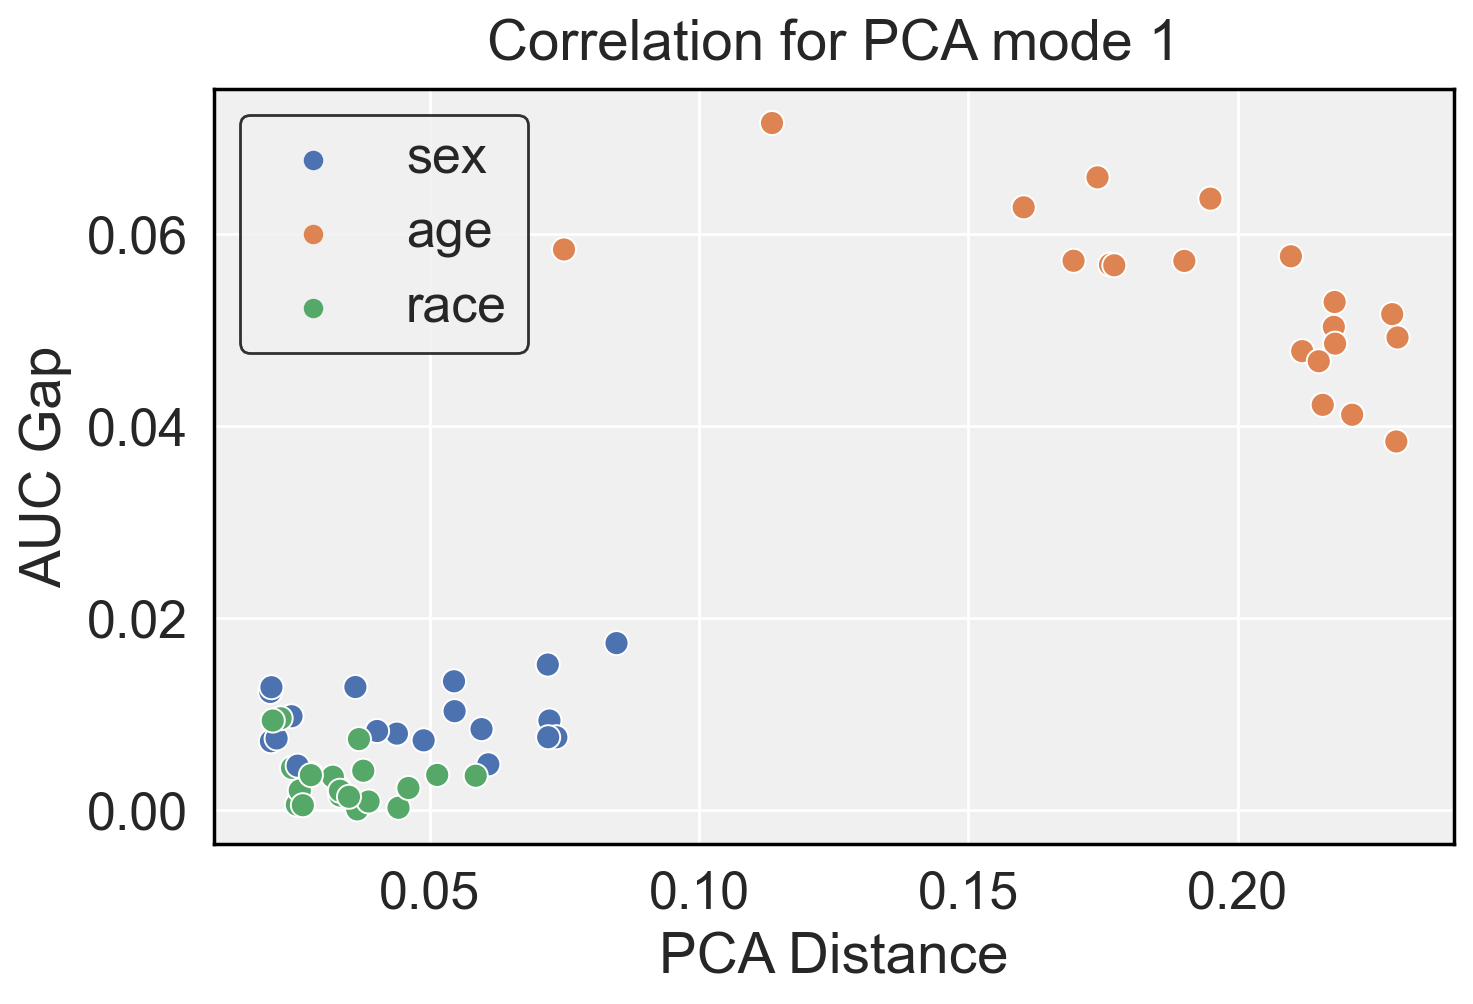

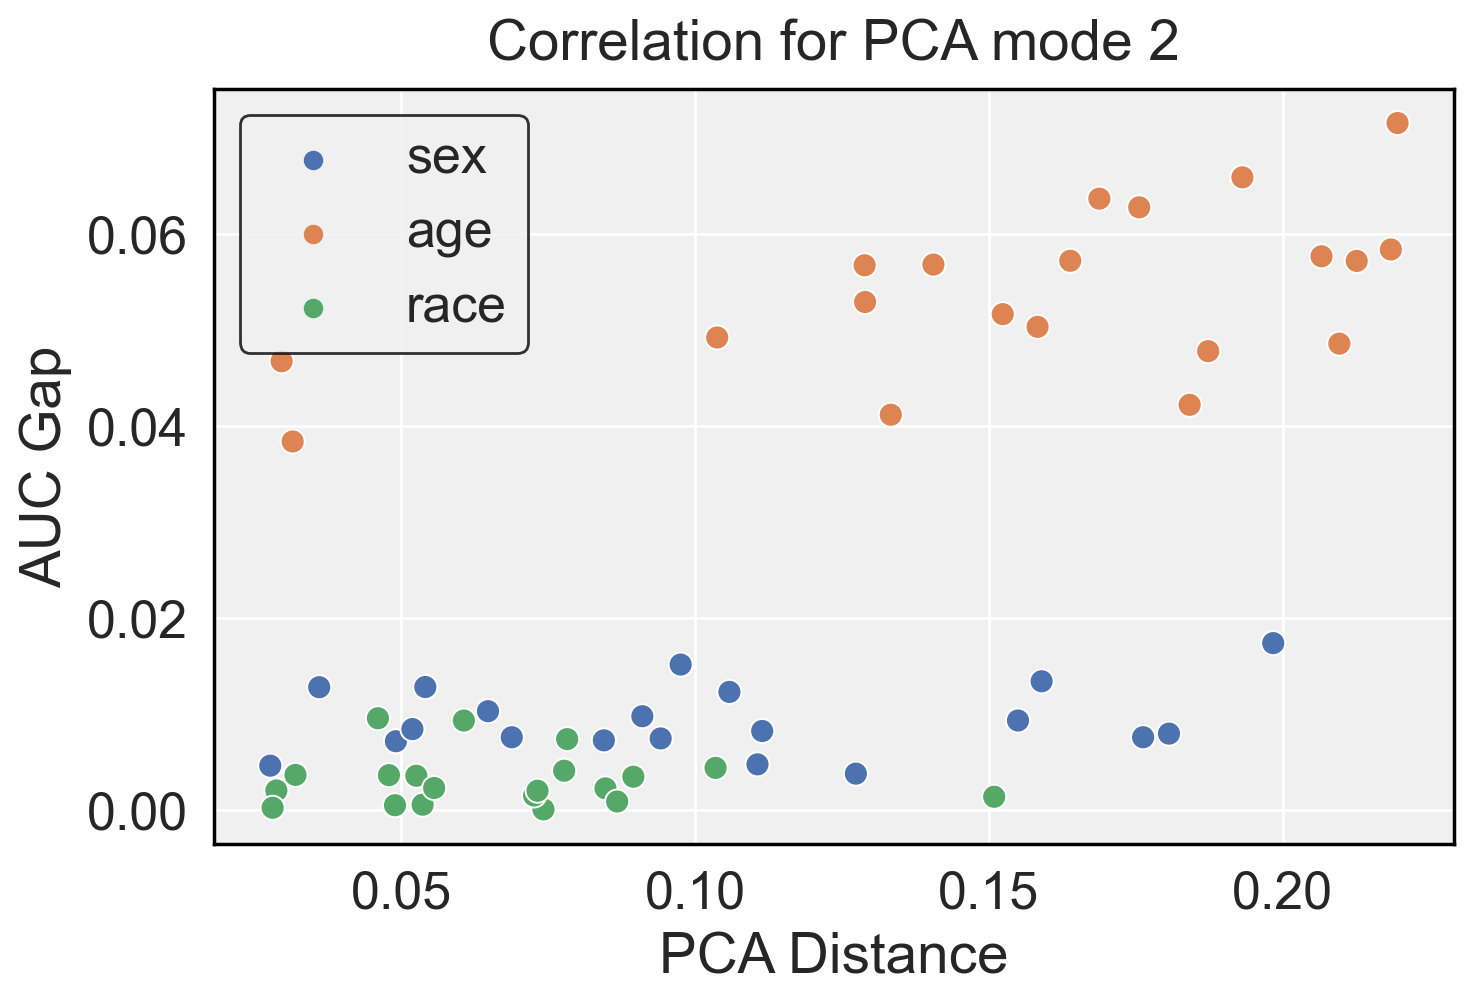

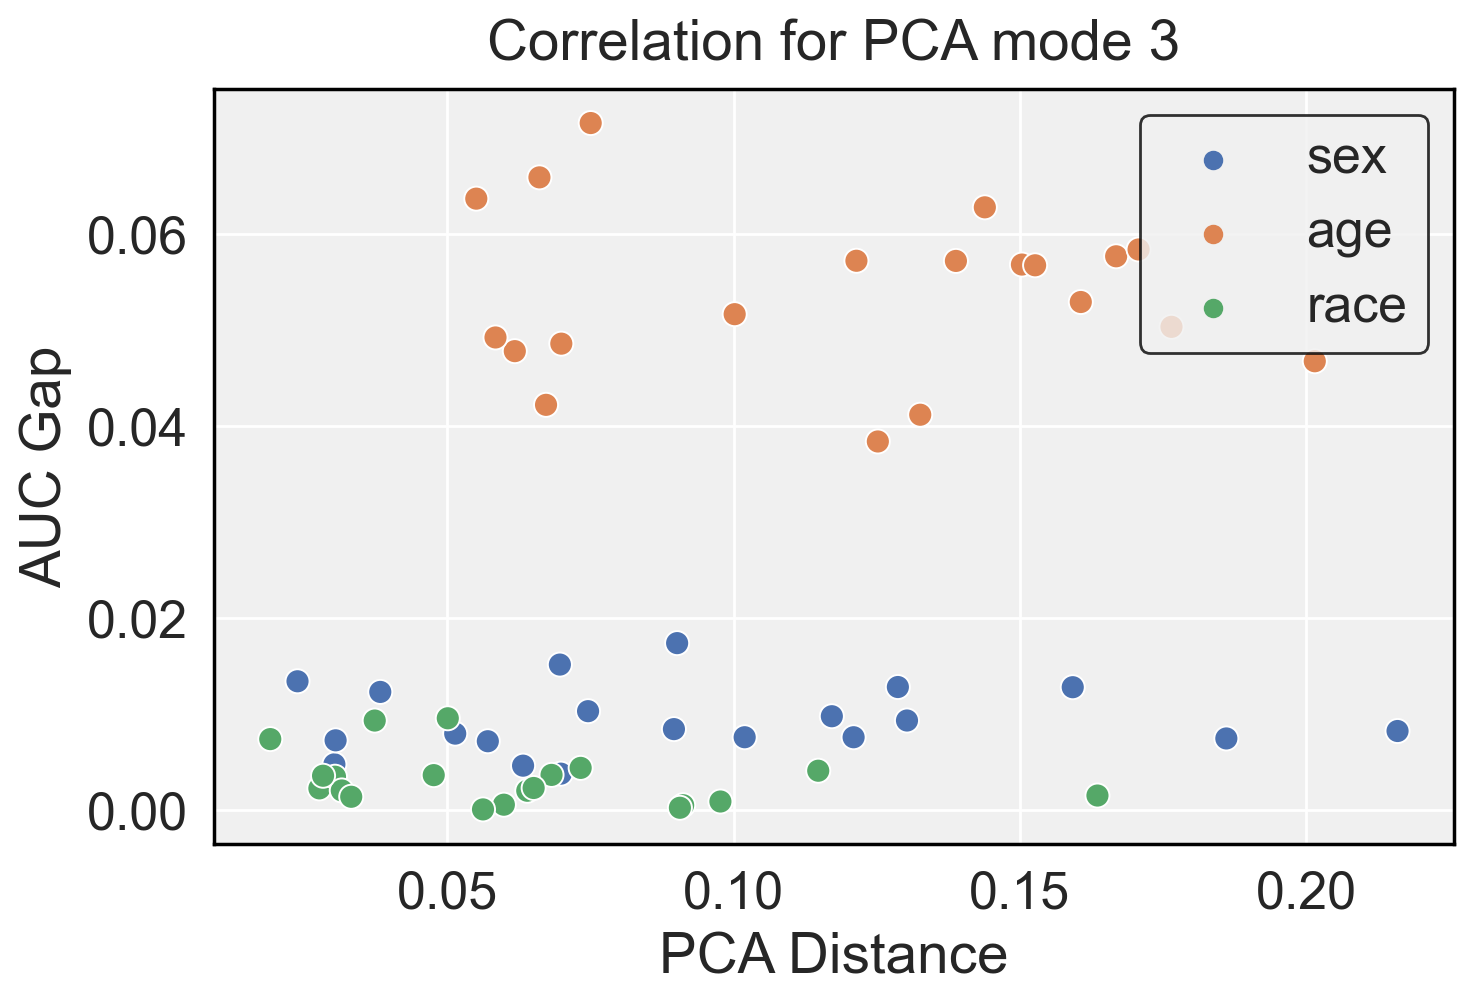

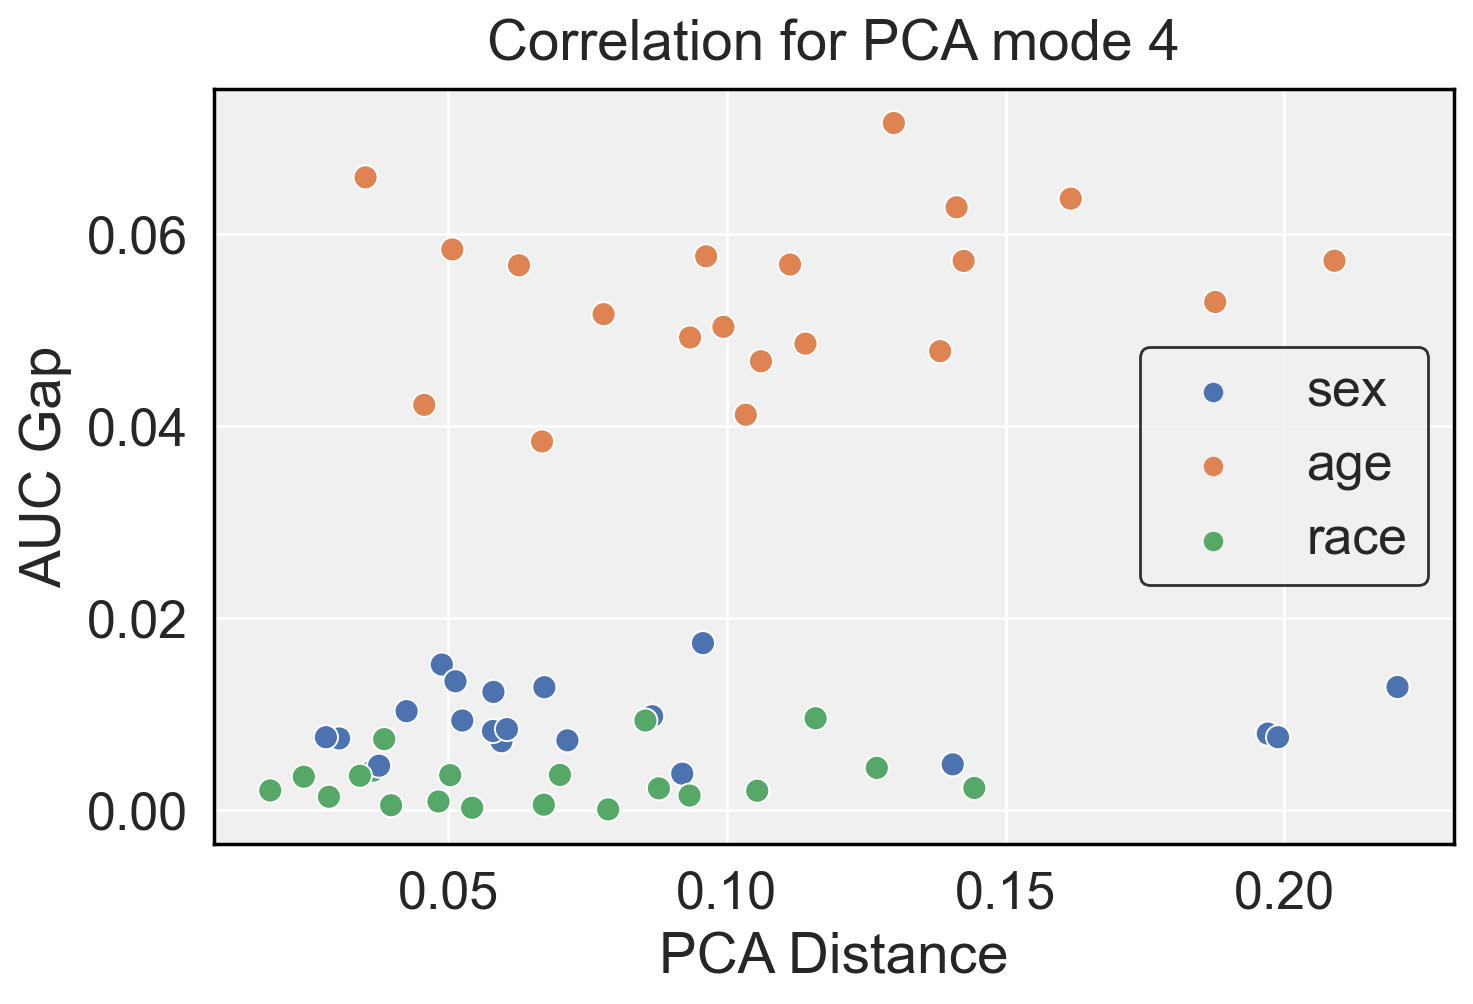

In [47]:
# Plotting
plt.rcParams['figure.dpi'] = 200
pcas = auc_scatter_df['PCA'].unique()

for i, pca in enumerate(pcas):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=auc_scatter_df[auc_scatter_df['PCA'] == pca], 
                    x='PCA_dist', 
                    y='auc_gap_relative', 
                    hue='attribute',
                    s=75)
    plt.title(f'Correlation for PCA mode {i+1}', y=1.015)
    plt.xlabel('PCA Distance', labelpad=5)
    plt.ylabel('AUC Gap', labelpad=5)
    # set face color
    ax = plt.gca()
    ax.set_facecolor('#F0F0F0')
    # set border and color
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    # set legend face color
    leg = plt.legend()
    leg.set_alpha(0.2)
    leg.get_frame().set_facecolor('#F0F0F0')
    # legend's border color:
    leg.get_frame().set_edgecolor('black')

    plt.show()
    

# PCA Modes similarity before & after KD

In [6]:
def pca_comparison_data(
    model_dir: str,
    is_student: bool,
    is_kd: bool,
    is_teacher: bool,
    teacher_id: str = None,
):
    # Look for the folders that have 'sam1' in them

    # TODO: THIS WORKS ONLY FOR STUDENT MODELS BUT I THINK WE ONLY DO RANDOM WEIGHTED SAMPLING
    if is_student:
        folders = [f for f in os.listdir(model_dir) if 'sam1' in f and ('r18' in f or 'r34' in f)]
    else:
        folders = [f for f in os.listdir(model_dir) if 'sam1' in f]


    if is_teacher:
        folders = [f for f in folders if teacher_id in f]

    if is_kd:
        assert teacher_id is not None
        folders = [f for f in folders if teacher_id in f]

    # Go to each folder and load 'embeds.csv' and 'test_predictions.csv'
    data = []
    for folder in folders:
        df = pd.read_csv(f'{model_dir}/{folder}/test.csv')

        # Create PCA
        embeds_df = pd.read_csv(f'{model_dir}/{folder}/embeds.csv')
        embeds = np.array(embeds_df.iloc[:,0:MODEL_FEATURES[df['model_name'].iloc[0]]])

        create_pca(embeds, embeds_df)
        sim_df = create_sim_table(embeds_df)
        sim_df = sim_df.reset_index()
        sim_df = sim_df.rename(columns={'index': 'PCA'})

        sim_df['avg_subgroup_sim'] = (sim_df['sex_dist'] + sim_df['race_dist'] + sim_df['age_dist']) / 3
        sim_df['model_id'] = df['model_id'].iloc[0]
        sim_df['model_name'] = df['model_name'].iloc[0]
        sim_df['teacher_id'] = df['teacher_id'].iloc[0]
        sim_df['teacher_name'] = df['teacher_name'].iloc[0]

        data.append(sim_df)

        # if len(data) == 2:
        #     break

    df = pd.concat(data)
    return df


In [7]:
no_female = pca_comparison_data(
    model_dir='../../results/chexpert_no_female/resnet',
    is_student = True,
    is_kd = False,
    is_teacher = False,
)
print(no_female.shape)
no_female_kd = pca_comparison_data(
    model_dir='../../results/chexpert_no_female/kd',
    is_student = True,
    is_kd = True,
    teacher_id='r34-sam1-s43',
    is_teacher = False,
)
print(no_female_kd.shape)
no_feamel_faeture = pca_comparison_data(
    model_dir='../../results/chexpert_no_female/kd-feature_rgb',
    is_student = True,
    is_kd = True,
    teacher_id='r34-sam1-s43',
    is_teacher = False,
)
print(no_feamel_faeture.shape)


no_old = pca_comparison_data(
    model_dir='../../results/chexpert_no_old/resnet',
    is_student = True,
    is_kd = False,
    is_teacher = False,
)
print(no_old.shape)
no_old_kd = pca_comparison_data(
    model_dir='../../results/chexpert_no_old/kd',
    is_student = True,
    is_kd = True,
    teacher_id='r34-sam1-s43',
    is_teacher = False,
)
print(no_old_kd.shape)
no_old_feature = pca_comparison_data(
    model_dir='../../results/chexpert_no_old/kd-feature_rgb',
    is_student = True,
    is_kd = True,
    teacher_id='r34-sam1-s43',
    is_teacher = False,
)
print(no_old_feature.shape)


no_white = pca_comparison_data(
    model_dir='../../results/chexpert_no_white/resnet',
    is_student = True,
    is_kd = False,
    is_teacher = False,
)
print(no_white.shape)
no_white_kd = pca_comparison_data(
    model_dir='../../results/chexpert_no_white/kd',
    is_student = True,
    is_kd = True,
    teacher_id='r34-sam1-s43',
    is_teacher = False,
)
print(no_white_kd.shape)
no_white_feature = pca_comparison_data(
    model_dir='../../results/chexpert_no_white/kd-feature_rgb',
    is_student = True,
    is_kd = True,
    teacher_id='r34-sam1-s43',
    is_teacher = False,
)
print(no_white_feature.shape)

teacher_df = pca_comparison_data(
    model_dir='../../results/chexpert/resnet',
    is_student = False,
    is_kd = False,
    is_teacher = True,
    teacher_id='r34-sam1-s43',
)
print(teacher_df.shape)

(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(4, 10)


In [49]:
def plot_similarity_grouped_barplot(
    teacher_df: pd.DataFrame,
    students_df_kd: pd.DataFrame,
    students_df_feature: pd.DataFrame,
    metric: str,
    title: str = '',
):
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    # Prepare KD data
    # r18_before_kd = students_df_kd[(students_df_kd['model_name'] == 'resnet18') & pd.isna(students_df_kd['teacher_id'])]
    # r18_before_kd['label'] = 'Avg Resnet18 w/o KD'
    # r18_after_kd = students_df_kd[(students_df_kd['model_name'] == 'resnet18') & pd.notna(students_df_kd['teacher_id'])]
    # r18_after_kd['label'] = 'Avg Resnet18 w/ KD'
    # r34_before_kd = students_df_kd[(students_df_kd['model_name'] == 'resnet34') & pd.isna(students_df_kd['teacher_id'])]
    # r34_before_kd['label'] = 'Avg Resnet34 w/o KD'
    # r34_after_kd = students_df_kd[(students_df_kd['model_name'] == 'resnet34') & pd.notna(students_df_kd['teacher_id'])]
    # r34_after_kd['label'] = 'Avg Resnet34 w/ KD'


    # Prepare KD data
    before_kd = students_df_kd[pd.isna(students_df_kd['teacher_id'])]
    before_kd['label'] = 'Avg w/o KD'
    after_kd = students_df_kd[pd.notna(students_df_kd['teacher_id'])]
    after_kd['label'] = 'Avg w/ Vanilla KD'

    feature_after = students_df_feature[pd.notna(students_df_feature['teacher_id'])]
    feature_after['label'] = 'Avg w/ Feature KD'

    teacher_df['label'] = 'Teacher'

    # df = pd.concat([teacher_df, r18_before_kd, r18_after_kd, r34_before_kd, r34_after_kd])
    df = pd.concat([teacher_df, before_kd, after_kd, feature_after])

    colors = ["salmon", "wheat", "sienna", "plum", "purple"]
    colors = ["salmon", "lightskyblue", "orange", "forestgreen", "purple"]

    # --------- only for display - not needed for the actual plot ------------

    df = df.drop(columns=['avg_subgroup_sim'])
    display_df = df.groupby(['PCA', 'label']).mean()
    display(display_df.round(3))


    def compute_difference(df, column):
        pivot_df = df.pivot_table(index='label', columns='PCA', values=column)
        diff_df = pivot_df.subtract(pivot_df.loc['Teacher'], axis=1)
        diff_df = diff_df.stack().reset_index(name=f'{column}_diff')
        diff_df = diff_df[diff_df['label'] != 'Teacher']
        return diff_df

    columns_to_diff = [col for col in display_df.columns if col not in ['PCA', 'label']]
    result_df = compute_difference(display_df, columns_to_diff[0])
    for col in columns_to_diff[1:]:
        diff_df = compute_difference(df, col)
        result_df = pd.merge(result_df, diff_df, on=['PCA', 'label'])
    result_df = result_df.set_index(['label', 'PCA'])
    display(result_df.round(3))


    g = sns.catplot(
        data=df, kind="bar",
        x="PCA", y=metric, hue="label", errorbar="sd", height=6, estimator=np.mean, aspect=1.5, capsize=0.05, errwidth=1.2, palette=colors,
    )

    g.ax.set_axisbelow(True)

    # Set the custom y-scale
    min_val = df[metric].min()
    max_val = df[metric].max()
    plt.ylim(min_val - 0.05 * abs(min_val), max_val + 0.05 * abs(max_val))
    # plt.ylim(0, 0.2)

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')

    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)


    # Set titles
    plt.xlabel('')
    plt.title(title)

    # Move the legend outside and adjust its position
    # plt.tight_layout()  # Ensures the plot and legend do not overlap
    # legend.set_bbox_to_anchor((1.02, 0.5))  # Adjust the coordinates for desired positioning


    # Add a gap between bars in the same group
    for bar_container in g.ax.containers:
        for bar in bar_container:
            x = bar.get_x()
            width = bar.get_width()
            centre = x + width / 2.

            bar.set_x(centre - (0.8 * width / 2.))  # 0.9 controls the size of the gap; smaller values create a bigger gap
            bar.set_width(0.8 * width)  # The bar width is reduced to 90% to create the gap

    plt.rcParams['figure.dpi'] = 100
    plt.show()

### Table

### Plot

In [50]:
no_female['data'] = 'no female'
no_female_kd['data'] = 'no female'
no_feamel_faeture['data'] = 'no female'
no_old['data'] = 'no old'
no_old_kd['data'] = 'no old'
no_old_feature['data'] = 'no old'
no_white['data'] = 'no white'
no_white_kd['data'] = 'no white'
no_white_feature['data'] = 'no white'

student_df = pd.concat([no_female, no_female_kd, no_old, no_old_kd, no_white, no_white_kd])
student_feature = pd.concat([no_female, no_feamel_faeture, no_old, no_old_feature, no_white, no_white_feature])

student_feature.head()

,PCA,label_dist,sex_dist,age_dist,race_dist,avg_subgroup_sim,model_id,model_name,teacher_id,teacher_name,data
0,PCA 1,0.470365,0.046861,0.163697,0.034519,0.081692,r34-sam1-s46,resnet34,NaN,NaN,no female
1,PCA 2,0.251239,0.112004,0.115703,0.062043,0.096583,r34-sam1-s46,resnet34,NaN,NaN,no female
2,PCA 3,0.142335,0.060480,0.163845,0.036123,0.086816,r34-sam1-s46,resnet34,NaN,NaN,no female
3,PCA 4,0.268652,0.077031,0.099686,0.038205,0.071641,r34-sam1-s46,resnet34,NaN,NaN,no female
0,PCA 1,0.510824,0.119371,0.191955,0.067538,0.126288,r18-sam1-s44,resnet18,NaN,NaN,no female


### All Unfair Datasets Averaged

/tmp/ipykernel_2800098/2342175126.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_kd['label'] = 'Avg w/o KD'
/tmp/ipykernel_2800098/2342175126.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_kd['label'] = 'Avg w/ Vanilla KD'
/tmp/ipykernel_2800098/2342175126.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

label_dist  sex_dist  age_dist  race_dist
PCA   label                                                       
PCA 1 Avg w/ Feature KD       0.549     0.042     0.203      0.030
      Avg w/ Vanilla KD       0.556     0.037     0.211      0.033
      Avg w/o KD              0.512     0.063     0.192      0.039
      Teacher                 0.560     0.040     0.212      0.033
PCA 2 Avg w/ Feature KD       0.356     0.116     0.191      0.085
      Avg w/ Vanilla KD       0.249     0.065     0.149      0.035
      Avg w/o KD              0.254     0.121     0.133      0.075
      Teacher                 0.332     0.111     0.187      0.073
PCA 3 Avg w/ Feature KD       0.213     0.162     0.079      0.122
      Avg w/ Vanilla KD       0.221     0.169     0.124      0.113
      Avg w/o KD              0.190     0.128     0.115      0.086
      Teacher                 0.185     0.216     0.062      0.164
PCA 4 Avg w/ Feature KD       0.337     0.127     0.141      0.122
      Avg w/ Vanilla KD       0.197     0.157     0.090      0.117
      Avg w/o KD              0.183     0.135     0.091      0.068
      Teacher                 0.286     0.058     0.138      0.093

label_dist_diff  sex_dist_diff  age_dist_diff  \
label             PCA                                                    
Avg w/ Feature KD PCA 1           -0.012          0.002         -0.009   
                  PCA 2            0.024          0.005          0.004   
                  PCA 3            0.028         -0.054          0.018   
                  PCA 4            0.051          0.069          0.003   
Avg w/ Vanilla KD PCA 1           -0.005         -0.003         -0.001   
                  PCA 2           -0.084         -0.046         -0.038   
                  PCA 3            0.036         -0.047          0.063   
                  PCA 4           -0.089          0.099         -0.048   
Avg w/o KD        PCA 1           -0.048          0.023         -0.020   
                  PCA 2           -0.078          0.010         -0.054   
                  PCA 3            0.004         -0.088          0.053   
                  PCA 4           -0.104          0.077         -0.047   

                         race_dist_diff  
label             PCA                    
Avg w/ Feature KD PCA 1          -0.004  
                  PCA 2           0.012  
                  PCA 3          -0.041  
                  PCA 4           0.029  
Avg w/ Vanilla KD PCA 1          -0.001  
                  PCA 2          -0.038  
                  PCA 3          -0.050  
                  PCA 4           0.024  
Avg w/o KD        PCA 1           0.005  
                  PCA 2           0.003  
                  PCA 3          -0.078  
                  PCA 4          -0.025

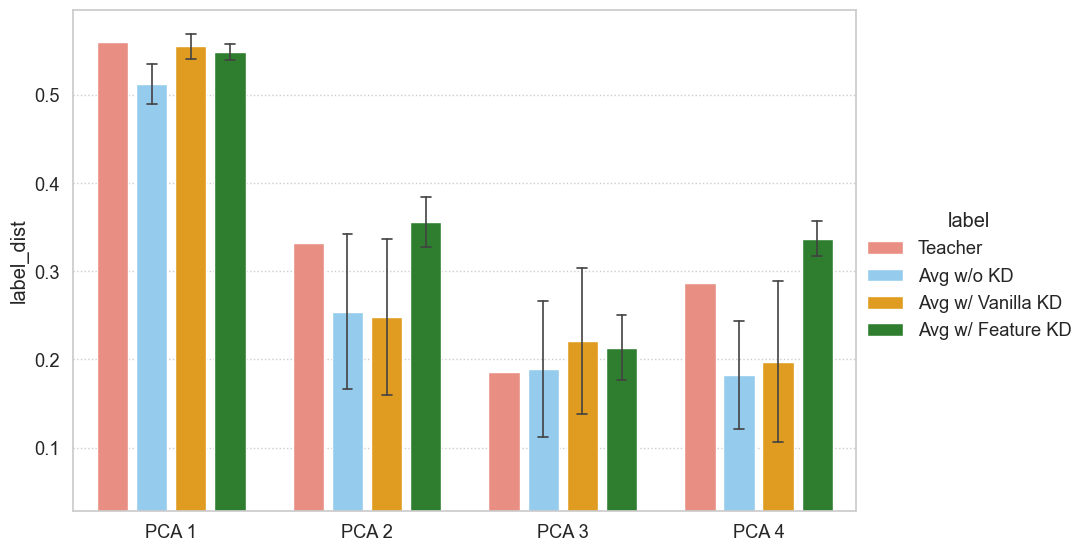

/tmp/ipykernel_2800098/2342175126.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_kd['label'] = 'Avg w/o KD'
/tmp/ipykernel_2800098/2342175126.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_kd['label'] = 'Avg w/ Vanilla KD'
/tmp/ipykernel_2800098/2342175126.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

label_dist  sex_dist  age_dist  race_dist
PCA   label                                                       
PCA 1 Avg w/ Feature KD       0.549     0.042     0.203      0.030
      Avg w/ Vanilla KD       0.556     0.037     0.211      0.033
      Avg w/o KD              0.512     0.063     0.192      0.039
      Teacher                 0.560     0.040     0.212      0.033
PCA 2 Avg w/ Feature KD       0.356     0.116     0.191      0.085
      Avg w/ Vanilla KD       0.249     0.065     0.149      0.035
      Avg w/o KD              0.254     0.121     0.133      0.075
      Teacher                 0.332     0.111     0.187      0.073
PCA 3 Avg w/ Feature KD       0.213     0.162     0.079      0.122
      Avg w/ Vanilla KD       0.221     0.169     0.124      0.113
      Avg w/o KD              0.190     0.128     0.115      0.086
      Teacher                 0.185     0.216     0.062      0.164
PCA 4 Avg w/ Feature KD       0.337     0.127     0.141      0.122
      Avg w/ Vanilla KD       0.197     0.157     0.090      0.117
      Avg w/o KD              0.183     0.135     0.091      0.068
      Teacher                 0.286     0.058     0.138      0.093

label_dist_diff  sex_dist_diff  age_dist_diff  \
label             PCA                                                    
Avg w/ Feature KD PCA 1           -0.012          0.002         -0.009   
                  PCA 2            0.024          0.005          0.004   
                  PCA 3            0.028         -0.054          0.018   
                  PCA 4            0.051          0.069          0.003   
Avg w/ Vanilla KD PCA 1           -0.005         -0.003         -0.001   
                  PCA 2           -0.084         -0.046         -0.038   
                  PCA 3            0.036         -0.047          0.063   
                  PCA 4           -0.089          0.099         -0.048   
Avg w/o KD        PCA 1           -0.048          0.023         -0.020   
                  PCA 2           -0.078          0.010         -0.054   
                  PCA 3            0.004         -0.088          0.053   
                  PCA 4           -0.104          0.077         -0.047   

                         race_dist_diff  
label             PCA                    
Avg w/ Feature KD PCA 1          -0.004  
                  PCA 2           0.012  
                  PCA 3          -0.041  
                  PCA 4           0.029  
Avg w/ Vanilla KD PCA 1          -0.001  
                  PCA 2          -0.038  
                  PCA 3          -0.050  
                  PCA 4           0.024  
Avg w/o KD        PCA 1           0.005  
                  PCA 2           0.003  
                  PCA 3          -0.078  
                  PCA 4          -0.025

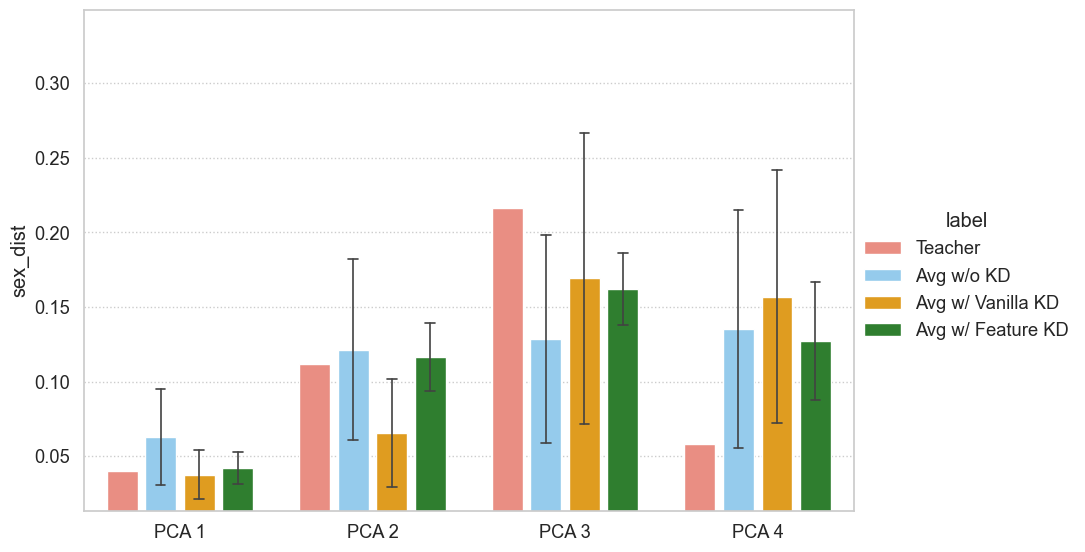

/tmp/ipykernel_2800098/2342175126.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_kd['label'] = 'Avg w/o KD'
/tmp/ipykernel_2800098/2342175126.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_kd['label'] = 'Avg w/ Vanilla KD'
/tmp/ipykernel_2800098/2342175126.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

label_dist  sex_dist  age_dist  race_dist
PCA   label                                                       
PCA 1 Avg w/ Feature KD       0.549     0.042     0.203      0.030
      Avg w/ Vanilla KD       0.556     0.037     0.211      0.033
      Avg w/o KD              0.512     0.063     0.192      0.039
      Teacher                 0.560     0.040     0.212      0.033
PCA 2 Avg w/ Feature KD       0.356     0.116     0.191      0.085
      Avg w/ Vanilla KD       0.249     0.065     0.149      0.035
      Avg w/o KD              0.254     0.121     0.133      0.075
      Teacher                 0.332     0.111     0.187      0.073
PCA 3 Avg w/ Feature KD       0.213     0.162     0.079      0.122
      Avg w/ Vanilla KD       0.221     0.169     0.124      0.113
      Avg w/o KD              0.190     0.128     0.115      0.086
      Teacher                 0.185     0.216     0.062      0.164
PCA 4 Avg w/ Feature KD       0.337     0.127     0.141      0.122
      Avg w/ Vanilla KD       0.197     0.157     0.090      0.117
      Avg w/o KD              0.183     0.135     0.091      0.068
      Teacher                 0.286     0.058     0.138      0.093

label_dist_diff  sex_dist_diff  age_dist_diff  \
label             PCA                                                    
Avg w/ Feature KD PCA 1           -0.012          0.002         -0.009   
                  PCA 2            0.024          0.005          0.004   
                  PCA 3            0.028         -0.054          0.018   
                  PCA 4            0.051          0.069          0.003   
Avg w/ Vanilla KD PCA 1           -0.005         -0.003         -0.001   
                  PCA 2           -0.084         -0.046         -0.038   
                  PCA 3            0.036         -0.047          0.063   
                  PCA 4           -0.089          0.099         -0.048   
Avg w/o KD        PCA 1           -0.048          0.023         -0.020   
                  PCA 2           -0.078          0.010         -0.054   
                  PCA 3            0.004         -0.088          0.053   
                  PCA 4           -0.104          0.077         -0.047   

                         race_dist_diff  
label             PCA                    
Avg w/ Feature KD PCA 1          -0.004  
                  PCA 2           0.012  
                  PCA 3          -0.041  
                  PCA 4           0.029  
Avg w/ Vanilla KD PCA 1          -0.001  
                  PCA 2          -0.038  
                  PCA 3          -0.050  
                  PCA 4           0.024  
Avg w/o KD        PCA 1           0.005  
                  PCA 2           0.003  
                  PCA 3          -0.078  
                  PCA 4          -0.025

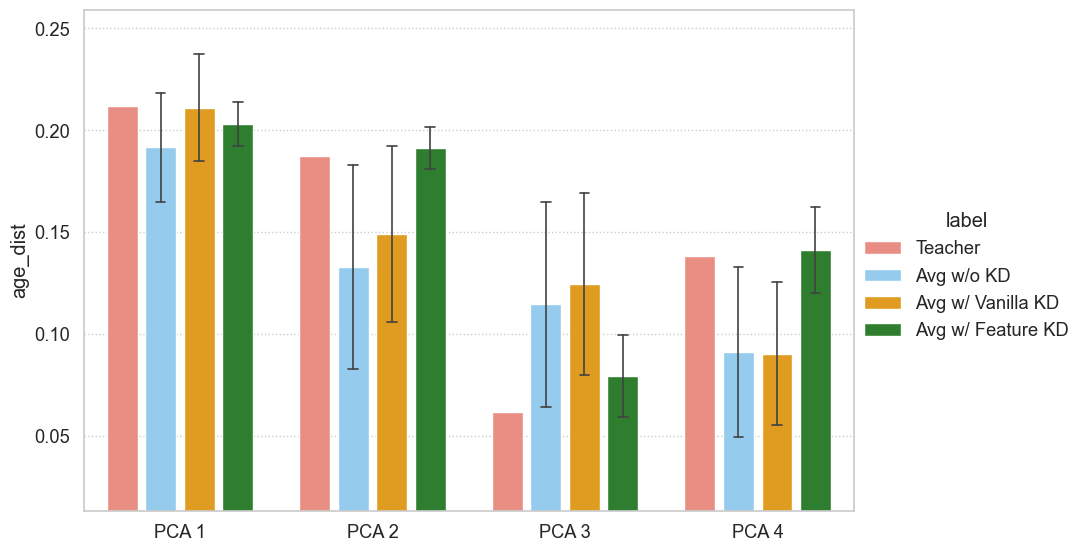

/tmp/ipykernel_2800098/2342175126.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_kd['label'] = 'Avg w/o KD'
/tmp/ipykernel_2800098/2342175126.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_kd['label'] = 'Avg w/ Vanilla KD'
/tmp/ipykernel_2800098/2342175126.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

label_dist  sex_dist  age_dist  race_dist
PCA   label                                                       
PCA 1 Avg w/ Feature KD       0.549     0.042     0.203      0.030
      Avg w/ Vanilla KD       0.556     0.037     0.211      0.033
      Avg w/o KD              0.512     0.063     0.192      0.039
      Teacher                 0.560     0.040     0.212      0.033
PCA 2 Avg w/ Feature KD       0.356     0.116     0.191      0.085
      Avg w/ Vanilla KD       0.249     0.065     0.149      0.035
      Avg w/o KD              0.254     0.121     0.133      0.075
      Teacher                 0.332     0.111     0.187      0.073
PCA 3 Avg w/ Feature KD       0.213     0.162     0.079      0.122
      Avg w/ Vanilla KD       0.221     0.169     0.124      0.113
      Avg w/o KD              0.190     0.128     0.115      0.086
      Teacher                 0.185     0.216     0.062      0.164
PCA 4 Avg w/ Feature KD       0.337     0.127     0.141      0.122
      Avg w/ Vanilla KD       0.197     0.157     0.090      0.117
      Avg w/o KD              0.183     0.135     0.091      0.068
      Teacher                 0.286     0.058     0.138      0.093

label_dist_diff  sex_dist_diff  age_dist_diff  \
label             PCA                                                    
Avg w/ Feature KD PCA 1           -0.012          0.002         -0.009   
                  PCA 2            0.024          0.005          0.004   
                  PCA 3            0.028         -0.054          0.018   
                  PCA 4            0.051          0.069          0.003   
Avg w/ Vanilla KD PCA 1           -0.005         -0.003         -0.001   
                  PCA 2           -0.084         -0.046         -0.038   
                  PCA 3            0.036         -0.047          0.063   
                  PCA 4           -0.089          0.099         -0.048   
Avg w/o KD        PCA 1           -0.048          0.023         -0.020   
                  PCA 2           -0.078          0.010         -0.054   
                  PCA 3            0.004         -0.088          0.053   
                  PCA 4           -0.104          0.077         -0.047   

                         race_dist_diff  
label             PCA                    
Avg w/ Feature KD PCA 1          -0.004  
                  PCA 2           0.012  
                  PCA 3          -0.041  
                  PCA 4           0.029  
Avg w/ Vanilla KD PCA 1          -0.001  
                  PCA 2          -0.038  
                  PCA 3          -0.050  
                  PCA 4           0.024  
Avg w/o KD        PCA 1           0.005  
                  PCA 2           0.003  
                  PCA 3          -0.078  
                  PCA 4          -0.025

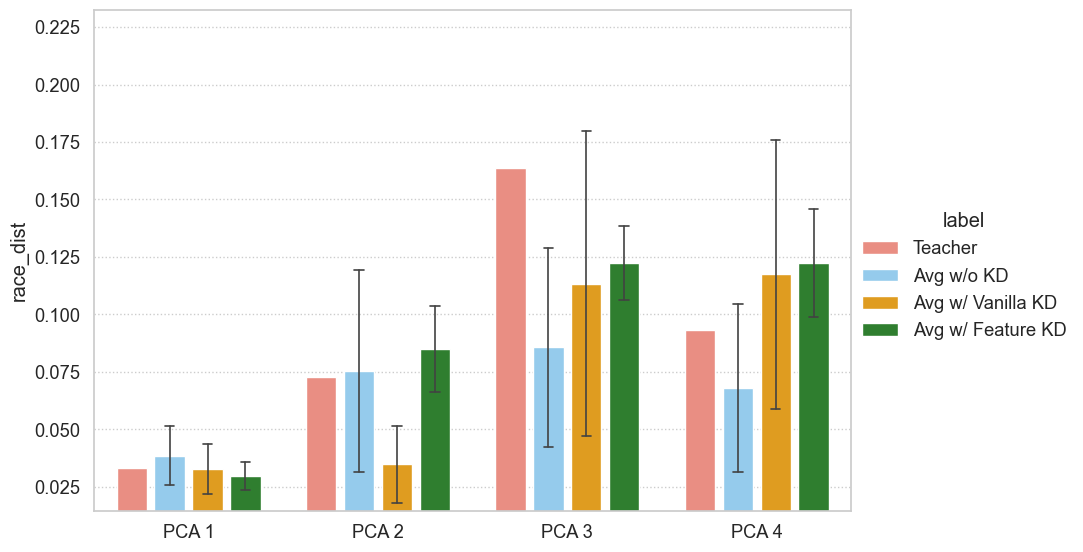

In [51]:
# TODO: Can do each dataset seperetely

plot_similarity_grouped_barplot(
    teacher_df,
    student_df,
    student_feature,
    metric='label_dist',
)

plot_similarity_grouped_barplot(
    teacher_df,
    student_df,
    student_feature,
    metric='sex_dist'
)

plot_similarity_grouped_barplot(
    teacher_df,
    student_df,
    student_feature,
    metric='age_dist'
)

plot_similarity_grouped_barplot(
    teacher_df,
    student_df,
    student_feature,
    metric='race_dist'
)